# Implementation 4 of the Image Classfication Model (46 Animals)

In [3]:
# Import the necessary libraries:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential# used for the model

### Dataset import:

In [4]:
# import the data:
import opendatasets as od
import pandas
dataset_path = "./uk-image-dataset"#path to the data

### Filter out corrupted Images:

In [5]:
from pathlib import Path
import imghdr

data_dir = dataset_path
image_extensions = [".png", ".jpg",".jpeg"]  #all images file extensions (they are accepted by tf)
count = 0

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    count=count+1
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            #os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            #os.remove(filepath)
            
print(count)#how much data I have left

C:\Users\Dima\AppData\Local\Temp\ipykernel_12520\677682611.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


13938


### Load in the dataset:

In [6]:
#Loading the Data in a faster and more efficient manner:
files = os.listdir(dataset_path)#gather the path:
#paths to the files
folder_path = os.path.join(dataset_path)#path to the images
#tf.keras.utils.image_dataset_from_directory?? # ?? allows me to see the documentation
data  = tf.keras.utils.image_dataset_from_directory(folder_path,image_size=(255,255))
print(type(data))

Found 13892 files belonging to 46 classes.
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


### Preprocessing the data:

In [7]:
data = data.map(lambda x,y: (x/255, y))# tf function map to rescale the images
print(type(data))

<class 'tensorflow.python.data.ops.map_op._MapDataset'>


### Visualising the data:

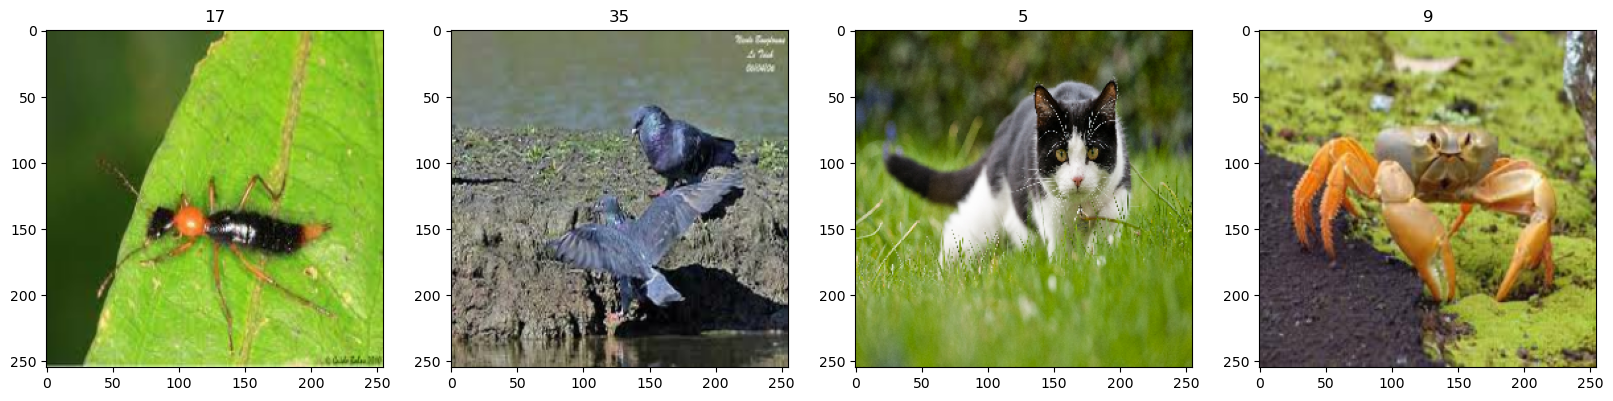

In [8]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
# batch[0].shape
#visualise the data:
fig, axis = plt.subplots(ncols=4, figsize=(20, 20))
batch_images = batch[0][:4]
batch_labels = batch[1]

for idx in range(4):
    axis[idx].imshow(batch_images[idx])
    axis[idx].title.set_text(batch_labels[idx])

### Split up the data:

In [9]:
print(batch[0].max())
print(batch[0].min())

#Split the data:
print("Length: ",len(data))
#Size for each batch: (70% train, 15% validation, 15% test)
train_size = round(len(data) * 0.7)
validation_size = round(len(data)*0.2)
test_size = len(data) - train_size - validation_size
print(train_size,validation_size,test_size)

1.0
0.0
Length:  435
304 87 44


In [10]:
#Alocate the Batches to the data:
train_data = data.take(train_size)
val_data = data.skip(train_size).take(validation_size)
test_data = data.skip(train_size+validation_size).take(test_size)

print(len(train_data))

304


In [11]:
training_data_iterator = train_data.as_numpy_iterator()
batch = training_data_iterator.next()

### Data augmentation:

In [30]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
])

#Function to apply data augmentation (Rotation and Horizontal Flip)
def apply_data_augmentation(images, labels):
    #Unpack the batch into images and labels
    augmented_images = data_augmentation(images)

    # Return a new dataset
    augmented_batch = (augmented_images, labels)
    
    return augmented_batch

In [31]:
train_data_augmented = train_data.map(apply_data_augmentation)

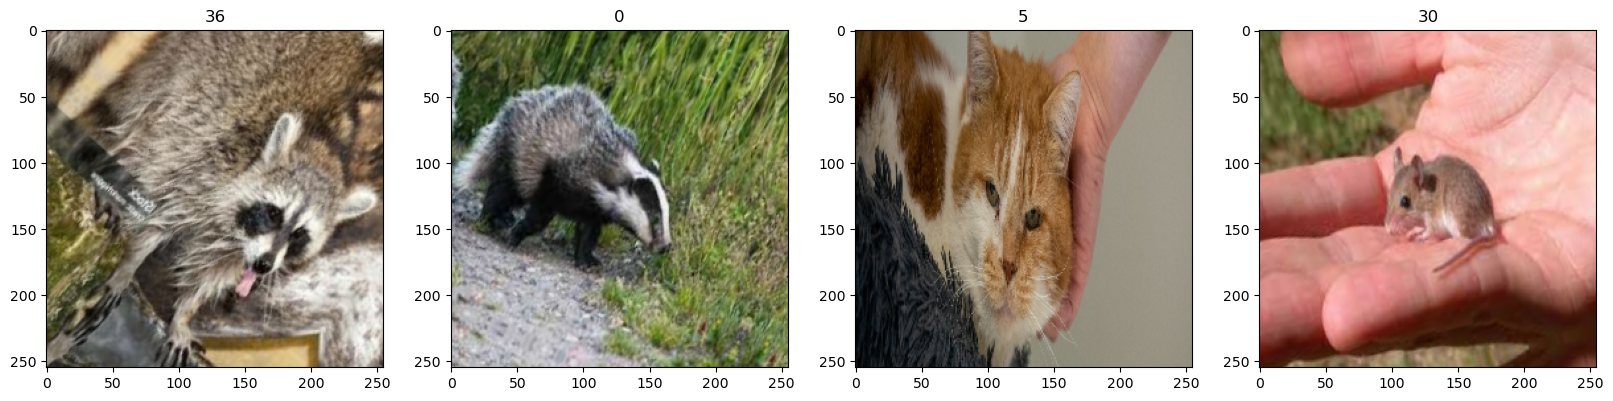

In [32]:
training_batch = train_data_augmented.as_numpy_iterator().next()

#visualise the data:
fig, axis = plt.subplots(ncols=4, figsize=(20, 20))
batch_images = training_batch[0][:4]
batch_labels = training_batch[1]

for idx in range(4):
    axis[idx].imshow(batch_images[idx])
    axis[idx].title.set_text(batch_labels[idx])

In [33]:
train_data = train_data.concatenate(train_data_augmented)#Combine the two dataset (data augmented and initial training dataset)

len(train_data)

608

### Train the Network

In [53]:
#import the relative layers
from tensorflow.keras.models import Sequential#model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation

In [54]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 3)))#input dimentions of the image
model.add(MaxPooling2D((2, 2)))#reduce dimentions of the input

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))#reduce dimentions of the input

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))#reduce dimentions of the input

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))#reduce dimentions of the input

#Flatten results:
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))#fully connected layers
model.add(Dense(46, activation='softmax'))#46 outputs



In [55]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'precision', 'recall'])
#metrics to measure the model's performance

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 253, 253, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 126, 126, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 30, 30, 64)       

In [56]:
history = model.fit(train_data, epochs=25, validation_data=val_data)#Shows the model's training

Epoch 1/25
608/608 [==============================] - 792s 1s/step - loss: 3.6996 - accuracy: 0.0542 - val_loss: 3.5084 - val_accuracy: 0.0941
Epoch 2/25
608/608 [==============================] - 921s 2s/step - loss: 3.3514 - accuracy: 0.1298 - val_loss: 3.2185 - val_accuracy: 0.1681
Epoch 3/25
608/608 [==============================] - 937s 2s/step - loss: 3.0853 - accuracy: 0.1928 - val_loss: 2.9745 - val_accuracy: 0.2324
Epoch 4/25
608/608 [==============================] - 812s 1s/step - loss: 2.7868 - accuracy: 0.2684 - val_loss: 2.8182 - val_accuracy: 0.2730
Epoch 5/25
608/608 [==============================] - 798s 1s/step - loss: 2.5158 - accuracy: 0.3302 - val_loss: 2.7564 - val_accuracy: 0.3010
Epoch 6/25
608/608 [==============================] - 798s 1s/step - loss: 2.2882 - accuracy: 0.3898 - val_loss: 2.6576 - val_accuracy: 0.3290
Epoch 7/25
608/608 [==============================] - 792s 1s/step - loss: 2.0654 - accuracy: 0.4465 - val_loss: 2.6217 - val_accuracy: 0.3369

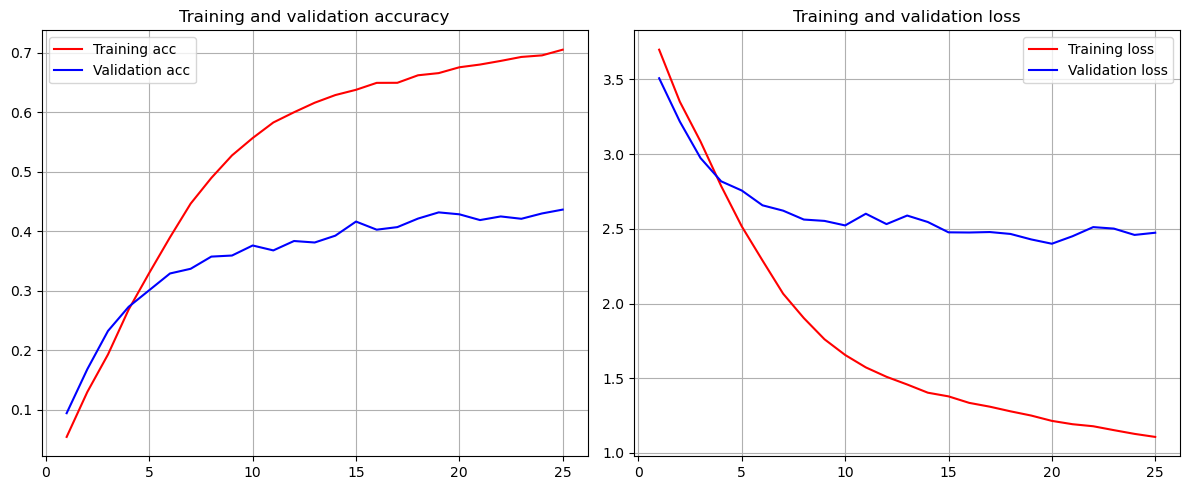

In [59]:
def visualise(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].plot(epochs, acc, 'r', label='Training acc')
    axs[0].plot(epochs, val_acc, 'b', label='Validation acc')
    axs[0].set_title('Training and validation accuracy')
    axs[0].grid(True)
    axs[0].legend()
    
    axs[1].plot(epochs, loss, 'r', label='Training loss')
    axs[1].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[1].set_title('Training and validation loss')
    axs[1].grid(True)
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()
visualise(history)

In [58]:
model.save_weights('accurate_model.h5')# To save the weights of the model

### Test model on Test data

In [60]:
test_results = model.evaluate(test_data)

# Print the test accuracy and loss
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

44/44 [==============================] - 123s 432ms/step - loss: 2.5954 - accuracy: 0.4094
Test Loss: 2.5953543186187744
Test Accuracy: 0.40942028164863586


### Load In the Weights & re-train:

In [7]:
model.load_weights('accurate_model.h5')

In [64]:
model.fit(train_data, epochs=5, validation_data=val_data)

Epoch 1/5
608/608 [==============================] - 798s 1s/step - loss: 1.0495 - accuracy: 0.7191 - val_loss: 2.5249 - val_accuracy: 0.4400
Epoch 2/5
608/608 [==============================] - 898s 1s/step - loss: 1.0313 - accuracy: 0.7238 - val_loss: 2.5475 - val_accuracy: 0.4300
Epoch 3/5
608/608 [==============================] - 1005s 2s/step - loss: 1.0269 - accuracy: 0.7241 - val_loss: 2.4324 - val_accuracy: 0.4476
Epoch 4/5
608/608 [==============================] - 933s 2s/step - loss: 0.9945 - accuracy: 0.7298 - val_loss: 2.5352 - val_accuracy: 0.4325
Epoch 5/5
608/608 [==============================] - 962s 2s/step - loss: 0.9942 - accuracy: 0.7319 - val_loss: 2.5680 - val_accuracy: 0.4185


In [65]:
model.save_weights('accurate_model.h5')# To save the weights of the model

### Test the model again:

In [66]:
test_results = model.evaluate(test_data)

# Print the test accuracy and loss
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

44/44 [==============================] - 45s 262ms/step - loss: 2.6824 - accuracy: 0.3978
Test Loss: 2.6823809146881104
Test Accuracy: 0.39782607555389404


### Data Augmentation (zoom and brightness)

In [105]:
data_augmentation_two = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomZoom(0.1),  # Adjust the zoom factor as needed
    layers.experimental.preprocessing.RandomContrast(0.1)  # Adjust the contrast factor as needed
])

#apply data augmentation (Zoom)
def apply_data_augmentation_zoom(images, labels):
    #Unpack the batch into images and labels
    augmented_images = data_augmentation_two(images)
    
    #Return a new dataset
    augmented_batch = (augmented_images, labels)
    return augmented_batch

train_data_augmented = train_data.map(apply_data_augmentation)

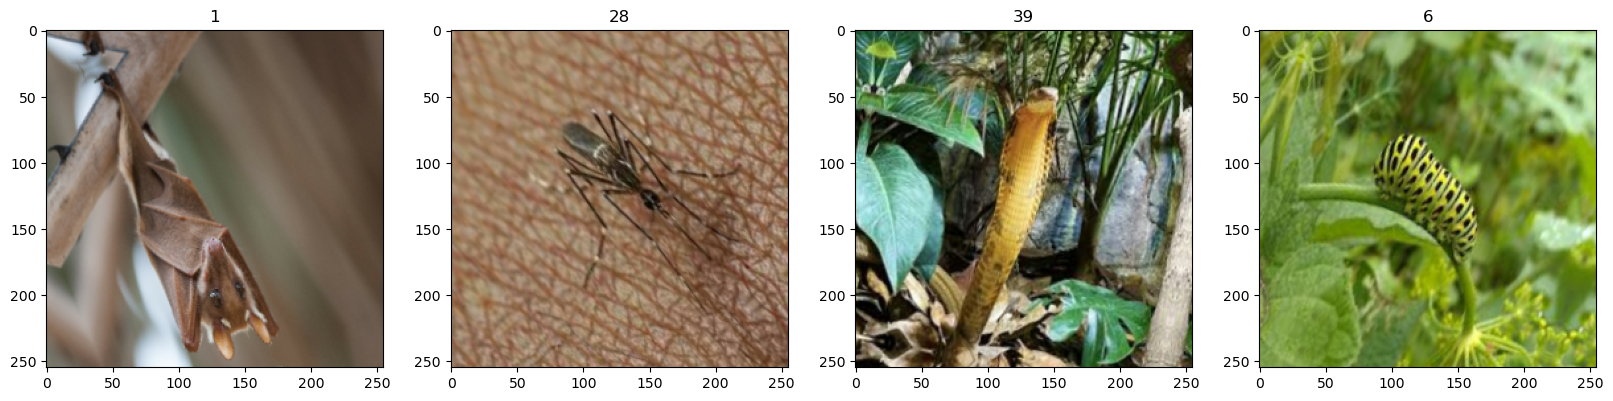

In [106]:
training_batch = train_data_augmented.as_numpy_iterator().next()

#visualise the data:
fig, axis = plt.subplots(ncols=4, figsize=(20, 20))
batch_images = training_batch[0][:4]
batch_labels = training_batch[1]

for idx in range(4):
    axis[idx].imshow(batch_images[idx])
    axis[idx].title.set_text(batch_labels[idx])

### Add the new augmented batch to training data:

In [107]:
train_data = train_data.concatenate(train_data_augmented)

len(train_data)

1216

### Train the Model:

In [108]:
history_three = model.fit(train_data, epochs=25, validation_data=val_data)

Epoch 1/25
1216/1216 [==============================] - 1582s 1s/step - loss: 1.4019 - accuracy: 0.6200 - val_loss: 2.5457 - val_accuracy: 0.4206
Epoch 2/25
1216/1216 [==============================] - 1646s 1s/step - loss: 1.3416 - accuracy: 0.6328 - val_loss: 2.5054 - val_accuracy: 0.4400
Epoch 3/25
1216/1216 [==============================] - 1665s 1s/step - loss: 1.2724 - accuracy: 0.6499 - val_loss: 2.6558 - val_accuracy: 0.4188
Epoch 4/25
1216/1216 [==============================] - 1679s 1s/step - loss: 1.2436 - accuracy: 0.6578 - val_loss: 2.6640 - val_accuracy: 0.4167
Epoch 5/25
1216/1216 [==============================] - 1688s 1s/step - loss: 1.1815 - accuracy: 0.6718 - val_loss: 2.6138 - val_accuracy: 0.4411
Epoch 6/25
1216/1216 [==============================] - 1771s 1s/step - loss: 1.1430 - accuracy: 0.6790 - val_loss: 2.6915 - val_accuracy: 0.4397
Epoch 7/25
1216/1216 [==============================] - 1691s 1s/step - loss: 1.1088 - accuracy: 0.6905 - val_loss: 2.7456 -

In [109]:
model.save_weights('accurate_model.h5')# To save the weights of the model

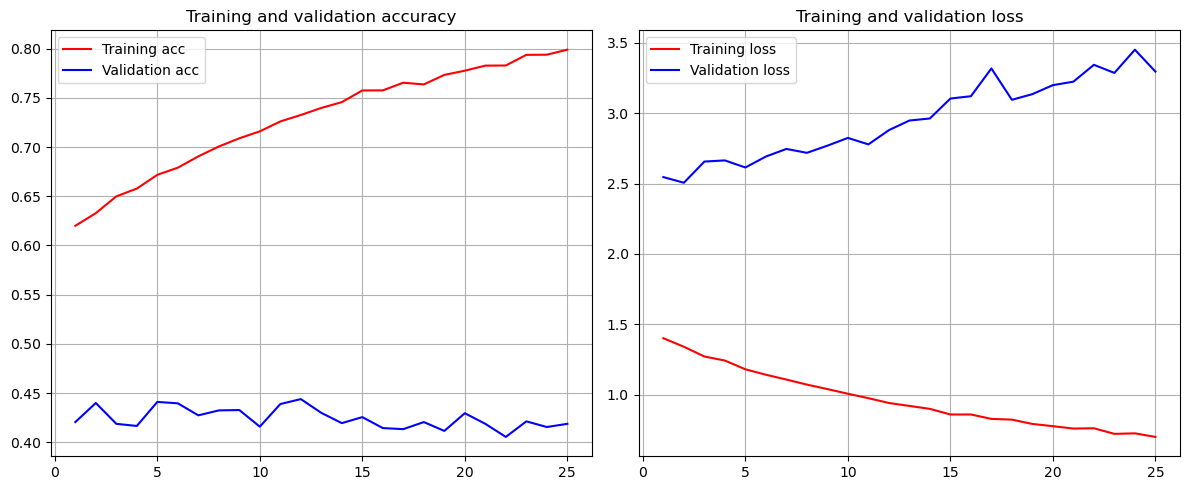

In [110]:
visualise(history_three)

### Test the model:

In [111]:
test_results = model.evaluate(test_data)

# Print the test accuracy and loss
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

44/44 [==============================] - 96s 412ms/step - loss: 3.5209 - accuracy: 0.3739
Test Loss: 3.5209169387817383
Test Accuracy: 0.373913049697876


### View which Class is poorly predicted:

In [129]:
#find all the animals that the model has misclassified:
wrongly_predicted_labels = []
list_of_all_predictions = []
#list to store total number of samples for each class:
total_samples_count = []
for batch in test_data.as_numpy_iterator():
    X, y_true = batch
    y_pred = model.predict(X)

    #Convert predictions to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)

    #Check for wrongly predicted labels
    for true_label, pred_label in zip(y_true, y_pred_classes):
        if true_label != pred_label:
            wrongly_predicted_labels.append((true_label, pred_label))
        list_of_all_predictions.append((true_label, pred_label))

1/1 [==============================] - 0s 81ms/step


In [159]:
def correct_incorrect_count(pred_y):
    TP = 0
    total = 0
    FP = 0
    for prediction in list_of_all_predictions:
        if(prediction[0] == pred_y):
            #total:
            total+=1
            #correct predictions:
            if(prediction[1] == pred_y):
                TP+=1
            #incorrect predictions:
            else:
                FP+=1
    return [TP,FP,total]   


### Evaluate each Class Performance:

In [187]:
list_of_misclassifications = []
for file in files:
    list_of_misclassifications.append((file, 0))

In [189]:
for i in wrongly_predicted_labels:
    index = i[0]#wrongly predicted index
    
    #update the list:
    currrent_val = list_of_misclassifications[index][1]
    label = list_of_misclassifications[index][0]
    
    list_of_misclassifications[index] = (label,currrent_val+1)

In [190]:
print(list_of_misclassifications)

[('badger', 20), ('bat', 19), ('bee', 23), ('beetle', 24), ('butterfly', 18), ('cat', 29), ('caterpillar', 11), ('cockroach', 18), ('cow', 25), ('crab', 16), ('crow', 15), ('deer', 27), ('dog', 20), ('donkey', 13), ('dragonfly', 9), ('duck', 18), ('eagle', 13), ('fly', 20), ('fox', 21), ('goat', 14), ('goose', 29), ('grasshopper', 16), ('hamster', 17), ('hare', 21), ('hedgehog', 13), ('horse', 21), ('ladybugs', 11), ('lobster', 20), ('mosquito', 15), ('moth', 27), ('mouse', 20), ('otter', 22), ('owl', 13), ('parrot', 13), ('pig', 24), ('pigeon', 20), ('racoon', 20), ('rat', 23), ('sheep', 14), ('snake', 25), ('sparrow', 14), ('squirrel', 25), ('swan', 19), ('turkey', 17), ('turtle', 17), ('woodpecker', 14)]


In [195]:
label_number = 21
print(files[label_number])
TP,FP,Total = correct_incorrect_count(label_number)
print(f"Correct: {TP} Incorrect: {FP} Total: {Total}")

grasshopper
Correct: 7 Incorrect: 16 Total: 23


# Transfer Learning Model:

In [2]:
tf.keras.applications??

In [13]:
#import the transfer learning model's weights:
from tensorflow.keras.applications import EfficientNetV2L
#include_top - include all 1000 images that this model has been trained on
transfer_model = EfficientNetV2L(weights='imagenet',
                        include_top=False,
                        input_shape=(255,255,3))

In [14]:
#for layer in model.layers[:-10]:
for layer in transfer_model.layers:#freezes the weights to make them fixed 
    layer.trainable = False

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D

model_four = Sequential()

model_four.add(transfer_model)#transfered learning model
model_four.add(GlobalAveragePooling2D())# takes the average of the conv layer
model_four.add(Dense(512, activation='relu'))#fully connected layers
model_four.add(Dropout(0.2))#has a 20% chance to drop each of the dense layers
model_four.add(Dense(512, activation='relu'))
model_four.add(Dropout(0.2))
model_four.add(Dense(46, activation='softmax'))#output layer


In [19]:
model_four.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Function  (None, 8, 8, 1280)        117746848 
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

## Train the transfered model:

In [22]:
#fine tuning - upadte the learning rate
#possibly add early stopping by motoring val loss
model_four.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
#training the model:
history_four = model_four.fit(train_data, epochs=30, validation_data=val_data)

Epoch 1/30
304/304 [==============================] - 5381s 18s/step - loss: 3.8330 - accuracy: 0.0219 - val_loss: 3.8243 - val_accuracy: 0.0277
Epoch 2/30
222/304 [====================>.........] - ETA: 20:07 - loss: 3.8212 - accuracy: 0.0293

KeyboardInterrupt: 

In [24]:
model_four.save('model_four_updated.keras')

In [ ]:
new_model = tf.keras.models.load_model('model_four.keras')#load the ziped model